# Evolution at High Mutation Rates

**Importing Modules**

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.special as special
import scipy.constants as constants
import math
import matplotlib.pyplot as plt

**Notebook Introduction**

Making an analytical model of evolution at high mutation rates is difficult without making simplifying assumptions. A well known model is Muller's Ratchet, which assumes a finite population size and is based on the stochastic loss of individuals with no or fewer mutations and assumes no back mutation. In an infinite population mutation can still lead to reduced fitness owing to mutational pressure. One nice model of this is Bull et al. (2007), which shows that, because of mutation-selection balance, the distribution of fitness effects (DFE) can be neglected and two key variables are the mutation rate and the base reproductive rate. When the reproductive rate is reduced below what is required for replacement by mutation load, the population is doomed. Unfortunately beneficial mutation is omitted in this model.

As Bull et al. (2013) reflect, their empirical work (and that of others) indicates that fitness can increase even as mutation load increases (e.g., Springman et al, 2010). If compensatory epistasis (see below) occurs (as might be expected from the fitness landscape metaphor) then recovery of fitness is possible even, or especially, when mutation load is high. It is therefore not adequate to assume a fixed DFE because it is expected that the availability of beneficial mutations will increase at low fitness, and decrease at high fitness changing the expected equilibrium fitness. Recent work (Rice et al., 2015) has examined how the DFE itself can evolve to an equilibrium.

In general, it seems there is a good motivation for a simulation here because other factors are involved as well as shifting DFEs, increasing the complexity of the situation. For example a population may be large enough that Muller's Ratchet has a long time constant at first, but this may become more important if fitness decreases and the population shrinks. Large viral populations may also be more likely to undergo recombination owing to high multiplicity of infection. And so on... 

This notebook explores some alternatives to DFE, in the context of work on epistasis, and then uses one of these to construct an individual-based simulation of evolution at high mutation rates. The focus is on phage studies owing to the author's research programme.

**The Vocabulary of Epistasis**

The following types of epistasis exist:
- positive epistasis (increases fitness above additive expectation),
- negative epistasis (decreases fitness below additive expectation),
- sign epistasis (changes expected beneficial effect into a deleterious change, or vice versa).

Positive and negative epistasis can take these stronger forms:
- compensatory epistasis (double mutants show higher fitness than either mutation alone),
- decompensatory mutations (double mutants show lower fitness than either mutation alone),
- diminishing-returns epistasis (each additional beneficial mutation has a reduced benefit).

These terms are deprecated:
- synergistic epistasis (increases magnitude of effect of combined beneficial (or deleterious) alleles),
- antagonistic epistasis (decreases magnitude of effect of combined beneficial (or deleterious) alleles).

**Phenotype-Fitness Mapping**

Pearson et al. (2012) observe a pattern of diminishing-returns epistasis when they explore the effect of genetic background on a focal beneficial mutation (actually two such) across several phages (relatives of φX174). They model this data by assuming linear effects of mutations and fitting a phenotype-fitness map using a Gamma distribution. This could be interesting for building a simulation that respects the fitness landscape although the author's indicate that decompensatory epistasis is commonly observed during adaptation and may be more common in this context than in comparative work. Here is their distribution:

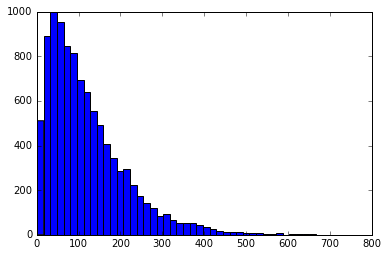

In [3]:
phen = stats.gamma(1.58,1,75.59)
plt.hist(phen.rvs(10000), 50) # random variates therefrom
plt.show() # not really required in a notebook - but useful in a script

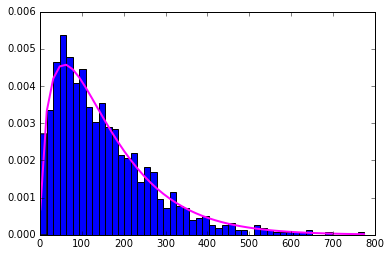

In [4]:
# Let's add a crude shape to it
shape, scale = 1.58, 100
phen = np.random.gamma(shape, scale, 1000)
count, bins, ignored = plt.hist(phen, 50, normed=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /(special.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='magenta')

I am having some difficulty here with the size variable, but this might be a viable way to side-step epistasis.

**Reflections on Model Requirements**

It would be nice to use the above phenotype-fitness map because it is fitted from real data. The key problem here is that we must allow beneficial mutations, but we must not permit arbitrarily high fitnesses to emerge under selection.

One way to constrain beneficial mutations at high fitness and facilitate them at low fitness is to add an epistasis modifier function and keep track of mutations, but this requires keeping track of the effect of sequential deleterious mutations.

The following two papers are worth consulting for the DFE of mutations in phiX174, but they do not provide a full state description:
- Domingo-Calap et al. (2009): The Fitness Effects of Random Mutations in Single-Stranded DNA and RNA Bacteriophages
- Vale et al. (2012): The Distribution of Mutational Fitness Effects of Phage φX174 on Different Hosts.

**A solution: Wylie's Physical Landscape**

Now I have read Wylie and Shakhnovich (2011, 2012) and they have a really nice model which provides a way to side-step epistasis altogether. The first paper describes a biophysical model of protein free energy (ΔG) and its relationship to fitness. This nicely recapitulates the DFE of non-synonymous mutations, except for lethals. The second paper builds on a simulation that uses this model and a Gaussian of changes in free energy (ΔΔG) - that is we have here a phenotype-fitness map that allows us to render a fitness effect of a new mutation directly from the current fitness.

Their model is tune-able with respect to reproductive rate (R, set to 2) and number of genes (set to 20). Rather than being a Wright-Fisher model, it runs a Moran-like process in which one individual is picked at a time for replication with a probability proportional to its fitness. A generation is ~N picks and N is the carrying capacity rather than the census population size (n). When n exceeds N individuals are culled with a probability proportional to their fitness. Soft selection therefore occurs in this model at n>=N, but selection is hard at n<N.

I need to consider whether R>2 requires switching to a Wright-Fisher approach. To reduce computational burden it may be necessary to assign a vector of offspring numbers, cull-filter it and then run the reproduce method (see implementation details below).

**The Boltzmann Constant**

In [5]:
# Boltzmann constant
constants.k # units: J/K - not what I want!
# Boltzmann constant
0.001987204118 # units: kcal/(mol⋅K) - thank you Wikipedia!

0.001987204118

**Working with ΔΔG (the phenotype Gaussian)**

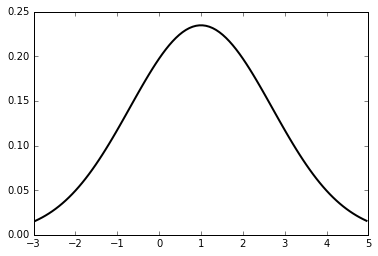

In [6]:
# let's plot deltadeltaG
dd_mean, dd_std = 1, 1.7
ddG = stats.norm(dd_mean, dd_std)
x = np.linspace(ddG.ppf(0.01),ddG.ppf(0.99), 100)
plt.plot(x, ddG.pdf(x), 'k-', lw=2)

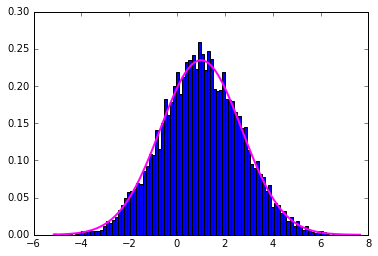

In [7]:
# Now let's pick some random variates from this distribution
rv_ddG = stats.norm.rvs(loc=dd_mean, scale=dd_std, size=10000)
# plot histogram and pdf over it
count, bins, ignored = plt.hist(rv_ddG, 100, normed=True)
y = ddG.pdf(bins)
plt.plot(bins, y, linewidth=2, color='magenta')

**Working with ΔG and ΔΔG**

For this section consult Wylie and Shakhnovich (2011). Equation 1 in their paper gives a function describing the fraction of time proteins spent in a correctly folded state. Some constant multiplied by the product of this fraction for each gene gives the fitness (equation 2). The fitness effect is approximated in equation 3. The code below replicates figure 1C (minus the kinks caused by lethality) - each line shows a different ΔΔG value.

(9.9999999999999995e-08, 1000.0)

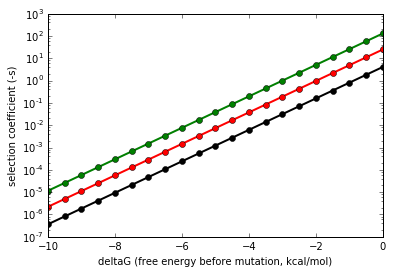

In [8]:
# setup for precision and constant terms
from decimal import getcontext, Decimal
getcontext().prec = 50 # I think this may be needed for powers and crazily small numbers
#getcontext().Emin = -1e22
#getcontext().Emax = 1e22
kt = Decimal(0.001987204118 * (273.15+37))

# some values for graphing
dG_values = [ Decimal(i) for i in np.arange(-10,0.5,0.5) ] # values here of -10, -9.5, .., 0.5, 0 for deltaG
ddG_values = [ Decimal(i) for i in range(1,4) ] # some values of deltadeltaG for plotting different lines

# selection coefficients - will populate using eq. 3
s_coeff = []
for i, ddG in enumerate(ddG_values):
    s_coeff.append( [ -float( Decimal(dG/kt).exp() * ( 1 - Decimal(ddG/kt).exp() ) ) for dG in dG_values ] )

# plotting
plt.yscale('log')
plt.plot(dG_values, s_coeff[0], color='black', lw=2, marker="o") #ddG = 1
plt.plot(dG_values, s_coeff[1], color='red', lw=2, marker="o") #ddG = 2
plt.plot(dG_values, s_coeff[2], color='green', lw=2, marker="o") #ddG = 3
plt.xlabel("deltaG (free energy before mutation, kcal/mol)")
plt.ylabel("selection coefficient (-s)")
ylim()

**Recapitulating the DFE**

In this section we use the random variates from the ΔΔG Gaussian we created above, as well as the fitness function to recover the distribution of fitness effects at different values of ΔG. This is a little bit like figure 3 in Wylie and Shakhnovich (2011) although it is actually closest to figure S1 in supplementary.

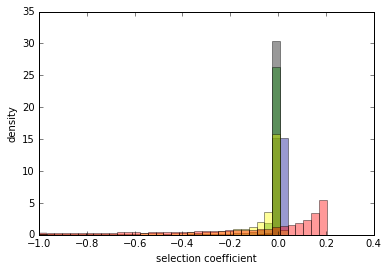

In [11]:
# setup for variables
# rem: rv_ddG is the random variates from the deltadeltaG distribution created above
dG_values = [ Decimal(dG) for dG in range(-7,0,2) ] # so these free energy values are from fig. S1

# population selection coefficients in 2D-array using eq. S2
s_coeff=[]
for dG in dG_values:
    s_coeff.append( [ float( Decimal(dG/kt).exp() * ( 1 - (Decimal(ddG)/kt).exp() ) ) for ddG in rv_ddG ] )
    
# plotting
count, bins, ignored = plt.hist(s_coeff[0], 20, range=(-1,0.3), normed=True, alpha=0.4, color="darkblue")
plt.hist(s_coeff[0], 40, range=(-1,0.3), normed=True, alpha=0.4, color="black") # dG = -7
plt.hist(s_coeff[1], 40, range=(-1,0.3), normed=True, alpha=0.4, color="green") # dG = -5
plt.hist(s_coeff[2], 40, range=(-1,0.3), normed=True, alpha=0.4, color="yellow") # dG = -3
plt.hist(s_coeff[3], 40, range=(-1,0.3), normed=True, alpha=0.4, color="red") # dG = -1
plt.xlabel("selection coefficient")
plt.ylabel("density")

Note that we are using variates here rather than fitting a nice smooth curve.

**Individual-based Simulation**

In this section I build a simulation based on the description in Wylie and Shakhnovich (2012).

In [53]:
# constants
kt = float(0.001987204118 * (273.15+37))
dd_mean, dd_std = 1, 1.7

# variables
Ud = 2 # non-synonymous mutations per genome per replication
L = 0.1 # proportion of lethal mutations
G = 10 # number of genes
N = 200 # carrying capacity
R = 2 # effective burst size
simlen = 1000 # number of generations
F = -5 # initial free energy of all proteins

In [54]:
# viral class
class Virus:
    def __init__(self, genes, deltag):
        self.genes = genes # stores mutation counts
        self.deltag = deltag # records current free energy
        self.fitness = self._fitness() # calculates fitness from free energy
        
    def _mutate(self):
        genes_int, deltag_int = self.genes, self.deltag # lists for mutations and free energies
        new_mutations = poisson(Ud) # no. of new mutations
        if np.random.rand(1) > np.power((1-L), new_mutations): # fraction L of mutations are lethal
            return None, None # so don't bother calculating, just return nothing
        else:
            ddG_values = stats.norm.rvs(loc=dd_mean, scale=dd_std, size=new_mutations) # deltadeltaG from Gaussian
            mutgene_coord = np.random.randint(0, G, new_mutations) # picking gene destined to have these mutations
            for index, gene_id in enumerate(mutgene_coord):
                genes_int[gene_id] += 1
                deltag_int[gene_id] = self.deltag[gene_id] + ddG_values[index]
                if deltag_int[gene_id] > 0: #in this case the fitness is zero
                    return None, None # so just return nothing and break out of function
            return genes_int, deltag_int

    def _fitness(self): # calculate fitness from product function
        return np.prod([ 1 / (1 + np.exp(dg/kt)) for dg in np.nditer(self.deltag) ])
    
    def reproduce(self):
        sprog = Virus(np.copy(self.genes), np.copy(self.deltag))
        sprog.genes, sprog.deltag = sprog._mutate()
        try:
            if sprog.genes.any(): # if lethal mutate() will have returned a None value
                sprog.fitness = sprog._fitness()
                return sprog
        except:
            return None # if Nones were returned, kill the sprog
        
    def __repr__(self): # for diagnostic printingS
        return "M"+str(np.sum(self.genes))+" F"+str(self.fitness)

In [55]:
# let's test this class with some instances
bob = Virus(np.zeros(10, dtype=int), np.array([F]*10, dtype=float))
print bob
bill, ben = bob.reproduce(), bob.reproduce()
print bob # has he changed?
print bill, ben # any deaths?

M0 F0.997007308817
M0 F0.997007308817
None M2 F0.979160456096


In [56]:
# initialise population
def initialise():
    population = [ Virus(np.zeros(G, dtype=int), np.array([F]*G, dtype=float)) for _ in range(N) ]
    return population

# function to help with multinomial picks
def get_weights(population):
    weights = [v.fitness for v in population]
    return weights/sum(weights)

# reporting function
def report_update(psiz, fit, free, mut):
    psiz.append( len(population) )
    fit.append( np.median([v.fitness for v in population]) )
    free.append( np.median([np.mean(v.deltag) for v in population]) )
    mut.append( np.median([sum(v.genes) for v in population]) )
    
# main simulation
population = initialise()
popsize = N
report_psiz, report_fit, report_free, report_mut = [], [], [], []

while simlen > 0:
    simlen -= 1
    for n in range(N):
        if popsize > N:
            population = list( np.random.choice(population, N, p = get_weights(population), replace=False) )
            popsize = N # why calculate when you can set?
        elif popsize == 0:
            simlen = 0 # they're all dead so let's end early (this is why I chose while loop)
            
        if popsize != 0: # pull an individual out of the population
            parent_index = np.random.choice(range(popsize), p=get_weights(population))
            parent = population.pop(parent_index)

            for r in range(R): # not sure whether to do this Moran process for R>2
                child = parent.reproduce()
                if child: # might be stillborn
                    population.append(child)
                    
        popsize = len(population)
                    
    report_update(report_psiz, report_fit, report_free, report_mut)

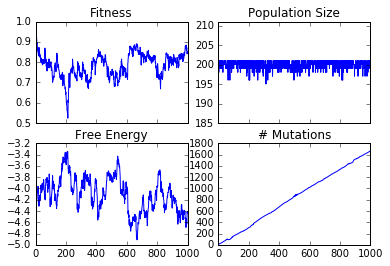

In [57]:
# Now let's graph the changes
f, axarr = plt.subplots(2, 2, sharex=True)
axarr[0,0].plot(report_fit)
axarr[0,0].set_title("Fitness")
axarr[0,1].plot(report_psiz)
axarr[0,1].set_title("Population Size")
axarr[0,1].set_ylim([min(report_psiz)-10,max(report_psiz)+10])
axarr[1,0].plot(report_free)
axarr[1,0].set_title("Free Energy")
axarr[1,1].plot(report_mut)
axarr[1,1].set_title("# Mutations")

**Questions**

- Do the proportion of lethal mutations (L) and the maximum reproductive capacity (R) interact linearly to determine the average time till extinction? This may be relevant in a chemostat in which offspring are washed away.
- Does Muller's Ratchet still occur in this system and does recombination (or shuffling between genes) help?
- Does recombination behave differently at different population sizes?
- Is there some interesting effect related to soft versus hard selection in this system? For example truncation selection against mildly deleterious mutants may be more efficient at n=N for this reason and not just because of the population size.

**References**

Bull, J. J., R. Sanjuán, and C. O. Wilke. 2007. Theory of lethal mutagenesis for viruses. J. Virol. 81:2930–2939.

Bull, J. J., P. Joyce, E. Gladstone, and I. J. Molineux. 2013. Empirical Complexities in the Genetic Foundations of Lethal Mutagenesis. Genetics 195:541–552.

Domingo-Calap, P., J. M. Cuevas, and R. Sanjuán. 2009. The Fitness Effects of Random Mutations in Single-Stranded DNA and RNA Bacteriophages. PLoS Genet 5:e1000742.

Pearson, V. M., C. R. Miller, and D. R. Rokyta. 2012. The consistency of beneficial fitness effects of mutations across diverse genetic backgrounds. PLoS One 7:e43864.

Rice, D. P., B. H. Good, and M. M. Desai. 2015. The evolutionarily stable distribution of fitness effects. Genetics 200:321–329.

Springman, R., T. Keller, I. J. Molineux, and J. J. Bull. 2010. Evolution at a high imposed mutation rate: Adaptation obscures the load in phage T7. Genetics 184:221–232.

Vale, P. F., M. Choisy, R. Froissart, R. Sanjuán, and S. Gandon. 2012. The Distribution of Mutational Fitness Effects of Phage ΦX174 on Different Hosts. Evolution (N. Y). 66:3495–3507.

Wylie, C. S., and E. I. Shakhnovich. 2011. A biophysical protein folding model accounts for most mutational fitness effects in viruses. Proc. Natl. Acad. Sci. U. S. A. 108:9916–21.

Wylie, C. S., and E. I. Shakhnovich. 2012. Mutation Induced Extinction in Finite Populations: Lethal Mutagenesis and Lethal Isolation. PLoS Comput Biol 8:e1002609.